<b> Standard imports for playing with and plotting data frames. </b>

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.stats.multitest
import random

<b> Import CPTAC data </b>

In [2]:
import CPTAC

Loading CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter CPTAC.embargo() to open the webpage for more details.


In [3]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

random.seed(0)

## Get the patients who have mutations in both PTEN and PIK3CA 

In [27]:
#create a dataframe with both mutations included 

mutation_1 = 'PIK3CA'
mutation_2 = 'PTEN'
common_mutated = somatic_mutations.loc[(somatic_mutations['Gene'] == mutation_1) | (somatic_mutations['Gene'] == mutation_2)]

mutations_first = somatic_mutations.loc[(somatic_mutations['Gene'] == mutation_1)]
#print(mutations_first['Clinical_Patient_Key'])

patients_first = mutations_first['Clinical_Patient_Key']
first_list = patients_first.tolist()
mutations_second = somatic_mutations.loc[somatic_mutations['Gene'] == mutation_2]
#print(mutations_second)
patients_second = mutations_second['Clinical_Patient_Key']
second_list = patients_second.tolist()

#get the number of unique patients in the pik3ca mutation list
unique_1 = list()
for person in first_list:
    if person not in unique_1:
        unique_1.append(person)

#check for the overlaps 
common_list = list()
for person in second_list:
    if person in unique_1:
        if person not in common_list:
            common_list.append(person)

print(len(common_list))
#print(common_list)

41


# Compare AKT1 Phosphoproteomics 

### Create a dataframe showing PTEN and PIK3CA mutations 

In [28]:
def combine_dataframes(gene_1, gene_2, site, dataframe):

    #create a dataframe for PIK3CA mutations
    phosdf_pik = CPTAC.compare_mutations(dataframe, site, gene_1)
    phosdf_pik = phosdf_pik.rename(index=str, columns={'Mutation' : 'Gene_1_Mutation'})

    #create a dataframe for PTEN mutations
    phosdf_pten = CPTAC.compare_mutations(dataframe, site, gene_2)
    phosdf_pten = phosdf_pten.rename(index=str, columns={'Mutation' : 'Gene_2_Mutation'})

    #extract the mutation column in PTEN that will be added to a combined dataframe
    pten_col = phosdf_pten['Gene_2_Mutation']

    #add the PTEN column to create a combined dataframe 
    phos_combined = phosdf_pik
    phos_combined['Gene_2_Mutation'] = pten_col

    #create new column to indicate if patient has mutations in both PIK3CA and PTEN
    phos_combined['Both_Mutations'] = False
    phos_combined.loc[common_list, 'Both_Mutations'] = True
    phos_combined.loc[(phos_combined['Gene_1_Mutation'] == 'Wildtype') & (phos_combined['Gene_2_Mutation'] == 'Wildtype'), 'Both_Mutations'] = 'Wildtype'
    #phos_combined.loc[(phos_combined['Gene_1_Mutation'] == 'Wildtype') | (phos_combined['Gene_2_Mutation'] == 'Wildtype') ]
    phos_combined.loc[(phos_combined['Gene_1_Mutation'] == 'Wildtype') & (phos_combined['Gene_2_Mutation'] != 'Wildtype'), 'Both_Mutations'] = (gene_2 + '_Only')
    #print(phos_combined)
    phos_combined.loc[(phos_combined['Gene_1_Mutation'] != 'Wildtype') & (phos_combined['Gene_2_Mutation'] == 'Wildtype'), 'Both_Mutations'] =  (gene_1 + '_Only')
    #print(phos_combined)
    #take out the control
    phos_combined.loc[phos_combined['Patient_Type'] == 'Normal', 'Both_Mutations'] = 'Normal'
    
    return phos_combined


### Both Mutations vs. Non-tumor

In [29]:
gene_1 = 'PIK3CA'
gene_2 = 'PTEN'
protein = 'AKT1'

phos_df = CPTAC.compare_mutations(phos, protein, gene_1)
#print(phos_df)

cutoff = 0.05/len(phos_df.columns)


#phos_df = phos_df['Patient_Type'].dropna(axis=0)
for site in phos_df.columns:
    if (site is not 'Mutation' and site is not 'Patient_Type'):
        
        sitedf = combine_dataframes(gene_1, gene_2,  site, phos)
        #print(sitedf)
        #print(sitedf)
        #mutateddf = sitedf.loc[(sitedf['Gene_1_Mutation'] != 'Wildtype') | (sitedf['Gene_2_Mutation'] != 'Wildtype') ].dropna(axis=1)
        #print(mutateddf)
        mutateddf = sitedf.loc[sitedf['Both_Mutations'] == True].dropna(axis = 0)
        #print(mutateddf)
        #print(mutateddf)
        #print(mutateddf)
        wtdf = sitedf.loc[(sitedf['Both_Mutations'] == 'Normal')].dropna(axis = 0)
        
        #print(wtdf)
        #wtdf = sitedf.loc[sitedf['Both_Mutations'] == False].dropna(axis=0)
        #wtdf = wtdf.loc[wtdf['Gene_1_Mutation'] == 'Wildtype']
        #wtdf = wtdf.loc[wtdf['Gene_2_Mutation'] == 'Wildtype']
        
        #print(wtdf[site])
        if site in wtdf.columns and site in mutateddf.columns:
            ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
            #print(ttest)
            if ttest[1] < cutoff:
                print(site, " ", ttest[1])
        #else: print("Unsignificant Results" , site, " ", ttest[1])



AKT1-S124   3.0973830825097156e-09
AKT1-S126   7.200404066034409e-07
AKT1-S129   1.639942257243254e-08
AKT1S1-S108   6.808557683501523e-05
AKT1S1-S112   0.001083569901724981
AKT1S1-S203   4.958249091904489e-05


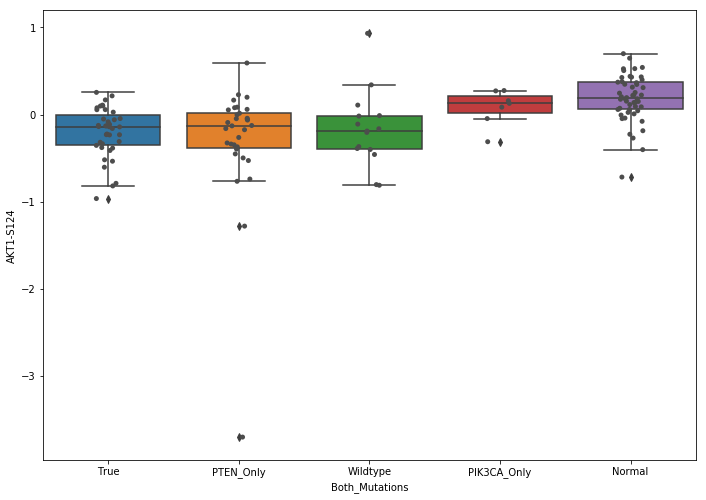

In [30]:
site = 'AKT1-S124'
sitedf = combine_dataframes(gene_1, gene_2, site, phos)

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

boxplt = sns.boxplot(data = sitedf, x = 'Both_Mutations', y = site)
boxplt = sns.stripplot(data = sitedf, x = 'Both_Mutations', y = site, jitter = True, color = '.3')
plt.show()

### Both Mutations vs. Wildtype_1 (PTEN Mutations Only)

In [8]:


phos_df = CPTAC.compare_mutations(phos, protein, gene_1)
#print(phos_df)

cutoff = 0.05/len(phos_df.columns)

for site in phos_df.columns:
    #print("site: ", site)
    if (site is not 'Mutation' and site is not 'Patient_Type'):
        #print(site)
        sitedf = combine_dataframes(gene_1, gene_2,  site, phos)
        #print(sitedf)
        #mutateddf = sitedf.loc[(sitedf['Gene_1_Mutation'] != 'Wildtype') | (sitedf['Gene_2_Mutation'] != 'Wildtype') ].dropna(axis=1)
        #print(mutateddf)
        mutateddf = sitedf.loc[sitedf['Both_Mutations'] == True].dropna(axis = 0)
        #print(mutateddf)
        #print(mutateddf)
        wtdf = sitedf.loc[(sitedf['Both_Mutations'] == (gene_2 + '_Only'))].dropna(axis = 0)
        #print(wtdf)
        #print(wtdf)
        #wtdf = sitedf.loc[sitedf['Both_Mutations'] == False].dropna(axis=0)
        #wtdf = wtdf.loc[wtdf['Gene_1_Mutation'] == 'Wildtype']
        #wtdf = wtdf.loc[wtdf['Gene_2_Mutation'] == 'Wildtype']
        
        #print(wtdf[site])
        if site in wtdf.columns and site in mutateddf.columns:
            ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
            #print(ttest)
            if ttest[1] < cutoff:
                print(site, " ", ttest[1])
            #else: print("Unsignificant Results" , site, " ", ttest)



/Users/emilyhosk/anaconda3/envs/research/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/emilyhosk/anaconda3/envs/research/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Both Mutations vs. Wildtype_2 (PIK3CA Mutations Only)

In [9]:


phos_df = CPTAC.compare_mutations(phos, protein, gene_1)
#print(phos_df)

cutoff = 0.05/len(phos_df.columns)
#print(cutoff)

for site in phos_df.columns:
    if (site is not 'Mutation'and site is not 'Patient_Type'):
        
        sitedf = combine_dataframes(gene_1, gene_2, site, phos)
        #print(sitedf)
        #mutateddf = sitedf.loc[(sitedf['Gene_1_Mutation'] != 'Wildtype') | (sitedf['Gene_2_Mutation'] != 'Wildtype') ].dropna(axis=1)
        #print(mutateddf)
        mutateddf = sitedf.loc[sitedf['Both_Mutations'] == True].dropna(axis=0)
        #print(mutateddf)
        #print(mutateddf)
        wtdf = sitedf.loc[(sitedf['Both_Mutations'] == (gene_1 + '_Only'))].dropna(axis=0)
        
        #print(wtdf)
        #wtdf = sitedf.loc[sitedf['Both_Mutations'] == False].dropna(axis=0)
        #wtdf = wtdf.loc[wtdf['Gene_1_Mutation'] == 'Wildtype']
        #wtdf = wtdf.loc[wtdf['Gene_2_Mutation'] == 'Wildtype']
        
        #print(wtdf[site])
        
        if site in wtdf.columns and site in mutateddf.columns:
            ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
            #print(ttest)
            if ttest[1] < cutoff:
                print(site, " ", ttest[1])
        else: print("Unsignificant Results" , site, " ", ttest[1])




### Wildtype_1 vs. Wildtype_2 (PTEN Mutations Only v PIK3CA Mutations Only)

In [10]:

phos_df = CPTAC.compare_mutations(phos, protein, gene_1)
#print(phos_df)

cutoff = 0.05/len(phos_df.columns)

for site in phos_df.columns:
    if (site is not 'Mutation'and site is not 'Patient_Type'):
        
        sitedf = combine_dataframes(gene_1, gene_2,  site, phos)
        #print(sitedf)
        #mutateddf = sitedf.loc[(sitedf['Gene_1_Mutation'] != 'Wildtype') | (sitedf['Gene_2_Mutation'] != 'Wildtype') ].dropna(axis=1)
        #print(mutateddf)
        mutateddf = sitedf.loc[sitedf['Both_Mutations'] == (gene_1 + '_Only')].dropna(axis=0)
        #print(mutateddf)
        #print(mutateddf)
        wtdf = sitedf.loc[(sitedf['Both_Mutations'] == (gene_2 + '_Only'))].dropna(axis=0)
        #print(wtdf)
        #print(wtdf)
        #wtdf = sitedf.loc[sitedf['Both_Mutations'] == False].dropna(axis=0)
        #wtdf = wtdf.loc[wtdf['Gene_1_Mutation'] == 'Wildtype']
        #wtdf = wtdf.loc[wtdf['Gene_2_Mutation'] == 'Wildtype']
        
        #print(wtdf[site])
        if site in wtdf.columns and site in mutateddf.columns:
            ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
            #print(ttest)
            if ttest[1] < cutoff:
                print(site, " ", ttest[1])
        else: print("Unsignificant Results" , site, " ", ttest[1])




### Both Mutations vs. Wildtype (No PTEN or PIK3CA mutations)

In [11]:

phos_df = CPTAC.compare_mutations(phos, protein, gene_1)
#print(phos_df)

cutoff = 0.05/len(phos_df.columns)

for site in phos_df.columns:
    if (site is not 'Mutation'and site is not 'Patient_Type'):
        
        sitedf = combine_dataframes(gene_1, gene_2,  site, phos)
        #print(sitedf)
        #mutateddf = sitedf.loc[(sitedf['Gene_1_Mutation'] != 'Wildtype') | (sitedf['Gene_2_Mutation'] != 'Wildtype') ].dropna(axis=1)
        #print(mutateddf)
        mutateddf = sitedf.loc[sitedf['Both_Mutations'] == True].dropna(axis=0)
        #print(mutateddf)
        #print(mutateddf)
        wtdf = sitedf.loc[(sitedf['Both_Mutations'] == 'Wildtype')].dropna(axis=0)
        
        #print(wtdf)
        #wtdf = sitedf.loc[sitedf['Both_Mutations'] == False].dropna(axis=0)
        #wtdf = wtdf.loc[wtdf['Gene_1_Mutation'] == 'Wildtype']
        #wtdf = wtdf.loc[wtdf['Gene_2_Mutation'] == 'Wildtype']
        
        #print(wtdf[site])
        if site in wtdf.columns and site in mutateddf.columns:
            ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
            #print(ttest)
            if ttest[1] < cutoff:
                print(site, " ", ttest[1])
        else: print("Unsignificant Results" , site, " ", ttest[1])




## PIK3CA Only vs Wildtype

In [12]:

phos_df = CPTAC.compare_mutations(phos, protein, gene_1)
#print(phos_df)

cutoff = 0.05/len(phos_df.columns)

for site in phos_df.columns:
    if (site is not 'Mutation'and site is not 'Patient_Type'):
        
        sitedf = combine_dataframes(gene_1, gene_2,  site, phos)
        #print(sitedf)
        #mutateddf = sitedf.loc[(sitedf['Gene_1_Mutation'] != 'Wildtype') | (sitedf['Gene_2_Mutation'] != 'Wildtype') ].dropna(axis=1)
        #print(mutateddf)
        mutateddf = sitedf.loc[sitedf['Both_Mutations'] == (gene_1 + '_Only')].dropna(axis=0)
        #print(mutateddf)
        #print(mutateddf)
        wtdf = sitedf.loc[(sitedf['Both_Mutations'] == 'Wildtype')].dropna(axis=0)
        #print(wtdf)
        #wtdf = sitedf.loc[sitedf['Both_Mutations'] == False].dropna(axis=0)
        #wtdf = wtdf.loc[wtdf['Gene_1_Mutation'] == 'Wildtype']
        #wtdf = wtdf.loc[wtdf['Gene_2_Mutation'] == 'Wildtype']
        
        #print(wtdf[site])
        if site in wtdf.columns and site in mutateddf.columns:
            ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
            #print("Unsig", site, " ",ttest)
            if ttest[1] < cutoff:
                print(site, " ", ttest[1])
            else: print("Unsignificant Results" , site, " ", ttest[1])



Unsignificant Results AKT1-S122   0.28545105646724306
Unsignificant Results AKT1-S124   0.166752300317427
Unsignificant Results AKT1-S126   0.11577748215509524
Unsignificant Results AKT1-S129   0.44376887891748107
Unsignificant Results AKT1-T450   nan
Unsignificant Results AKT1S1-S108   0.14250499539882358
Unsignificant Results AKT1S1-S112   0.2785437970784738
Unsignificant Results AKT1S1-S203   0.4963409602397756
Unsignificant Results AKT1S1-S222   0.2587642313687414
Unsignificant Results AKT1S1-S223   0.5782290553999969
Unsignificant Results AKT1S1-S231   0.39448680073333375
Unsignificant Results AKT1S1-S232   0.476939083576872
Unsignificant Results AKT1S1-S241   nan
Unsignificant Results AKT1S1-S267   0.3831846118940655
Unsignificant Results AKT1S1-T110   0.8219915066851784
Unsignificant Results AKT1S1-T117   0.2172786600084698
Unsignificant Results AKT1S1-T218   nan
Unsignificant Results AKT1S1-T266   0.9152078942825035
Unsignificant Results AKT1S1-T93   nan


# Protein Abundance Comparison

In [18]:
gene_1 = 'PIK3CA'
gene_2 = 'PTEN'
protein = 'PIK3CA'

prot_df = CPTAC.compare_mutations(proteomics, protein, gene_1)
#print(phos_df)

cutoff = 0.05/len(prot_df.columns)


        
sitedf = combine_dataframes(gene_1, gene_2, protein, proteomics)


sitedf = sitedf.dropna(axis = 0)

        
mutateddf = sitedf.loc[sitedf['Both_Mutations'] == 'Normal']
#print(mutateddf)
        
wtdf = sitedf.loc[(sitedf['Both_Mutations'] == gene_2 + '_only')]
print(wtdf)


if protein in wtdf.columns and site in mutateddf.columns:
    ttest = scipy.stats.ttest_ind(mutateddf[protein], wtdf[protein])
            #print(ttest)
    if ttest[1] < cutoff:
        print(protein, " ", ttest[1])
    else: print("Unsignificant Results" , site, " ", ttest[1])


Empty DataFrame
Columns: [PIK3CA, Gene_1_Mutation, Patient_Type, Gene_2_Mutation, Both_Mutations]
Index: []


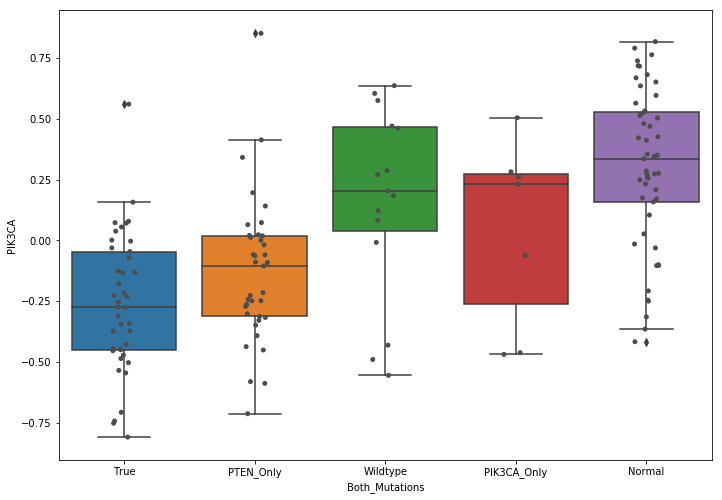

In [19]:
protein = 'PIK3CA'
sitedf = combine_dataframes(gene_1, gene_2, protein, proteomics)
#print(sitedf)

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

boxplt = sns.boxplot(data = sitedf, x = 'Both_Mutations', y = protein)
boxplt = sns.stripplot(data = sitedf, x = 'Both_Mutations', y = protein, jitter = True, color = '.3')
plt.show()